# Building chatbot using langgraph

In [ ]:
# installations required

# !pip install -qU ipyKernel
# !pip install -qU langgraph
# !pip install -qU typing-extensions
# !pip install -qU "langchain[google-genai]"
# !pip install -qU dotenv


[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [8]:
import os
from dotenv import load_dotenv

load_dotenv()

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

In [5]:
# Building basic chatbot using langgraph
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages] # annotated helps add metadata to the type. in this case it tells messages should be appended and not overwritten

graph_builder = StateGraph(State)

When defining a graph, the first step is to define its State. The State includes the graph's schema and reducer functions that handle state updates. In our example, State is a schema with one key: messages. The reducer function is used to append new messages to the list instead of overwriting it. Keys without a reducer annotation will overwrite previous values.

In [16]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=GEMINI_API_KEY)

In [17]:
llm.invoke("Hello, how are you?")  # basic test to check if llm is working

AIMessage(content="I am doing well, thank you for asking! As a large language model, I don't experience emotions or feelings in the same way humans do, but I am functioning optimally and ready to assist you. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--91b2b479-3283-4d58-9d7d-34c9eff2148d-0', usage_metadata={'input_tokens': 6, 'output_tokens': 50, 'total_tokens': 56, 'input_token_details': {'cache_read': 0}})

In [18]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

Notice how the chatbot node function takes the current State as input and returns a dictionary containing an updated messages list under the key "messages". This is the basic pattern for all LangGraph node functions.

The add_messages function in our State will append the LLM's response messages to whatever messages are already in the state.

In [19]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

In [20]:
graph = graph_builder.compile()

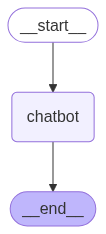

In [21]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [24]:
event_history = []

def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        event_history.append(event)
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: The weather in San Francisco right now is partly cloudy and 63°F. The wind is light, blowing from the west at 6 mph.
Assistant: Ah, New York! That's a broad question! To give you the most helpful answer, I need a little more information.  What specifically are you interested in knowing about New York?  For example, are you wondering about:

*   **New York City (NYC)?**
    *   **Specific boroughs:** Like Manhattan, Brooklyn, Queens, The Bronx, or Staten Island?
    *   **Things to do:** Tourist attractions, restaurants, nightlife, museums, parks, etc.?
    *   **Cost of living:** Rent, food, transportation, etc.?
    *   **Job market:** Specific industries or careers?
    *   **Real estate:** Buying or renting property?
    *   **Travel:** How to get there, where to stay, etc.?
    *   **Current events:** News, politics, local issues?
*   **New York State (NYS)?**
    *   **Specific regions:** Like the Hudson Valley, the Adirondacks, the Finger Lakes, etc.?
    *   **Travel 

In [25]:
from pprint import pprint

pprint(event_history)  # print the entire event history for debugging

[{'chatbot': {'messages': [AIMessage(content='The weather in San Francisco right now is partly cloudy and 63°F. The wind is light, blowing from the west at 6 mph.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--c0cf1caf-bddc-4f83-b4a0-781064b1988f-0', usage_metadata={'input_tokens': 9, 'output_tokens': 32, 'total_tokens': 41, 'input_token_details': {'cache_read': 0}})]}},
 {'chatbot': {'messages': [AIMessage(content="Ah, New York! That's a broad question! To give you the most helpful answer, I need a little more information.  What specifically are you interested in knowing about New York?  For example, are you wondering about:\n\n*   **New York City (NYC)?**\n    *   **Specific boroughs:** Like Manhattan, Brooklyn, Queens, The Bronx, or Staten Island?\n    *   **Things to do:** Tourist attractions, restaurants, nightlife, museums, parks, et